In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
sns.set(style='white', context='notebook', palette='deep')

# 1. Data Preparation#
## 1.1 Load Data

In [2]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

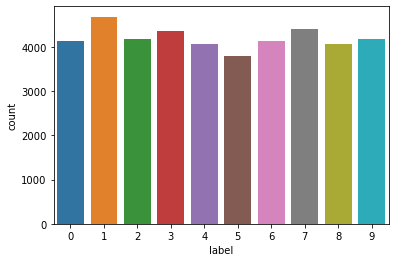

In [4]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

del train
graph = sns.countplot(Y_train)
Y_train.value_counts()

## 2.2 Check for null and missing values


Kiểm tra xem có giá trị nào là ảnh trắng không

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Normalization
Đơn giản hóa data vì nhận diện số nên chuẩn hóa vecto thang màu về
2 giá trị 0,1 để tính toán nhanh

In [7]:
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


## 2.5 Label One hot Encoding

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)


## 2.6 Split training and validation set

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)



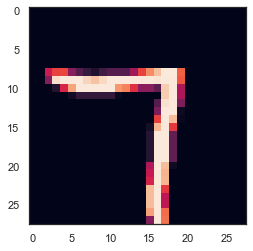

In [14]:
plt.imshow(X_train[9][:,:,0])

#3 CNN


## 3.1 Model


In [15]:
# add layer
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

## 3.2 Set the optimizer and annealer

In [17]:
#định nghĩa optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [18]:
#compile mô hình
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86


## 3.3 Data augmentation

In [21]:
# không sử dụng data augmentation có accuracy thấp hơn
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
#      validation_data = (X_val, Y_val), verbose = 2)

In [22]:
#data augmentation để tránh overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [23]:
# fit model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 117s - loss: 0.4000 - accuracy: 0.8715 - val_loss: 0.0558 - val_accuracy: 0.9829
Epoch 2/30
 - 138s - loss: 0.1299 - accuracy: 0.9616 - val_loss: 0.0461 - val_accuracy: 0.9860
Epoch 3/30
 - 157s - loss: 0.0962 - accuracy: 0.9718 - val_loss: 0.0419 - val_accuracy: 0.9869
Epoch 4/30
 - 130s - loss: 0.0796 - accuracy: 0.9755 - val_loss: 0.0354 - val_accuracy: 0.9895
Epoch 5/30
 - 131s - loss: 0.0733 - accuracy: 0.9781 - val_loss: 0.0330 - val_accuracy: 0.9902
Epoch 6/30
 - 131s - loss: 0.0678 - accuracy: 0.9805 - val_loss: 0.0294 - val_accuracy: 0.9917
Epoch 7/30
 - 134s - loss: 0.0651 - accuracy: 0.9818 - val_loss: 0.0248 - val_accuracy: 0.9921
Epoch 8/30
 - 140s - loss: 0.0604 - accuracy: 0.9822 - val_loss: 0.0303 - val_accuracy: 0.9900
Epoch 9/30
 - 123s - loss: 0.0594 - accuracy: 0.9823 - val_loss: 0.0299 - val_accuracy: 0.9910
Epoch 10/30
 - 115s - loss: 0.0612 - accuracy: 0.9829 - val_loss: 0.0341 - val_accuracy: 0.9900

Epoch 00010: ReduceLROnPlateau reducing learning

# 4 Evaluate the model
## 4.1 Training and validation curves

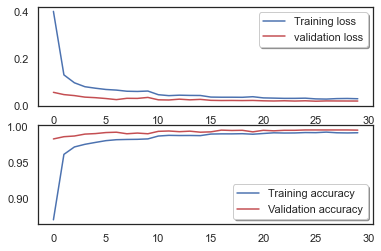

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

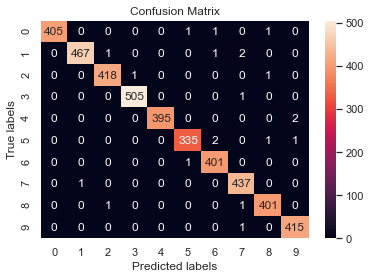

In [29]:
# dự đoán giá trị từ tập validate
Y_pred = model.predict(X_val)
# chuyển các class dự đoán được thành one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
# tính confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True, fmt='d')

# labels, title và ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

### plots một số dự đoán lỗi


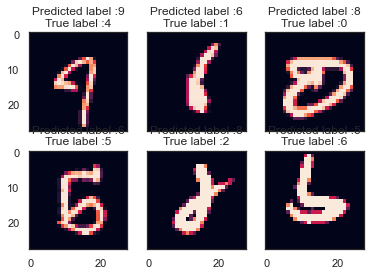

In [30]:
# Create plots on prediction errors

# Errors are differences between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [37]:
# dự đoán trên tập test
results = model.predict(test)
# lấy nhãn
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [41]:
results


0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64